
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from palmerpenguins import load_penguins
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [3]:
y = ha['cp']
X = ha.drop('cp',axis=1)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [4]:
ct2 = ColumnTransformer(
  [
    ("dummify", #Dummifying variables that need it
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object))
  ],
  remainder = "passthrough"
)

In [5]:
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", KNeighborsClassifier())
])
#Grid search grid
grid = {'model__n_neighbors': list(range(2,100,1))}  # Values for n_neighbors to be tested

#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

#Get best n and corresponding model score
best_n = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model Score:", best_score)
print("That model's N value:", best_n)

Best model Score: 0.4944107744107743
That model's N value: {'model__n_neighbors': 72}


In [6]:
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", DecisionTreeClassifier())
])
#Grid search grid
grid = {'model__criterion': ['gini','entropy','log_loss'],
        'model__splitter': ['best','random'],
        'model__max_depth': [None,2,10,20],
        'model__min_samples_split': list(range(2,11,1)),
        'model__min_samples_leaf': list(range(1,11,2))
       }

#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

#Get best params and corresponding model score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model Score:", best_score)
print("That model's used params:", best_params)

Best model Score: 0.5752188552188552
That model's used params: {'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__splitter': 'random'}


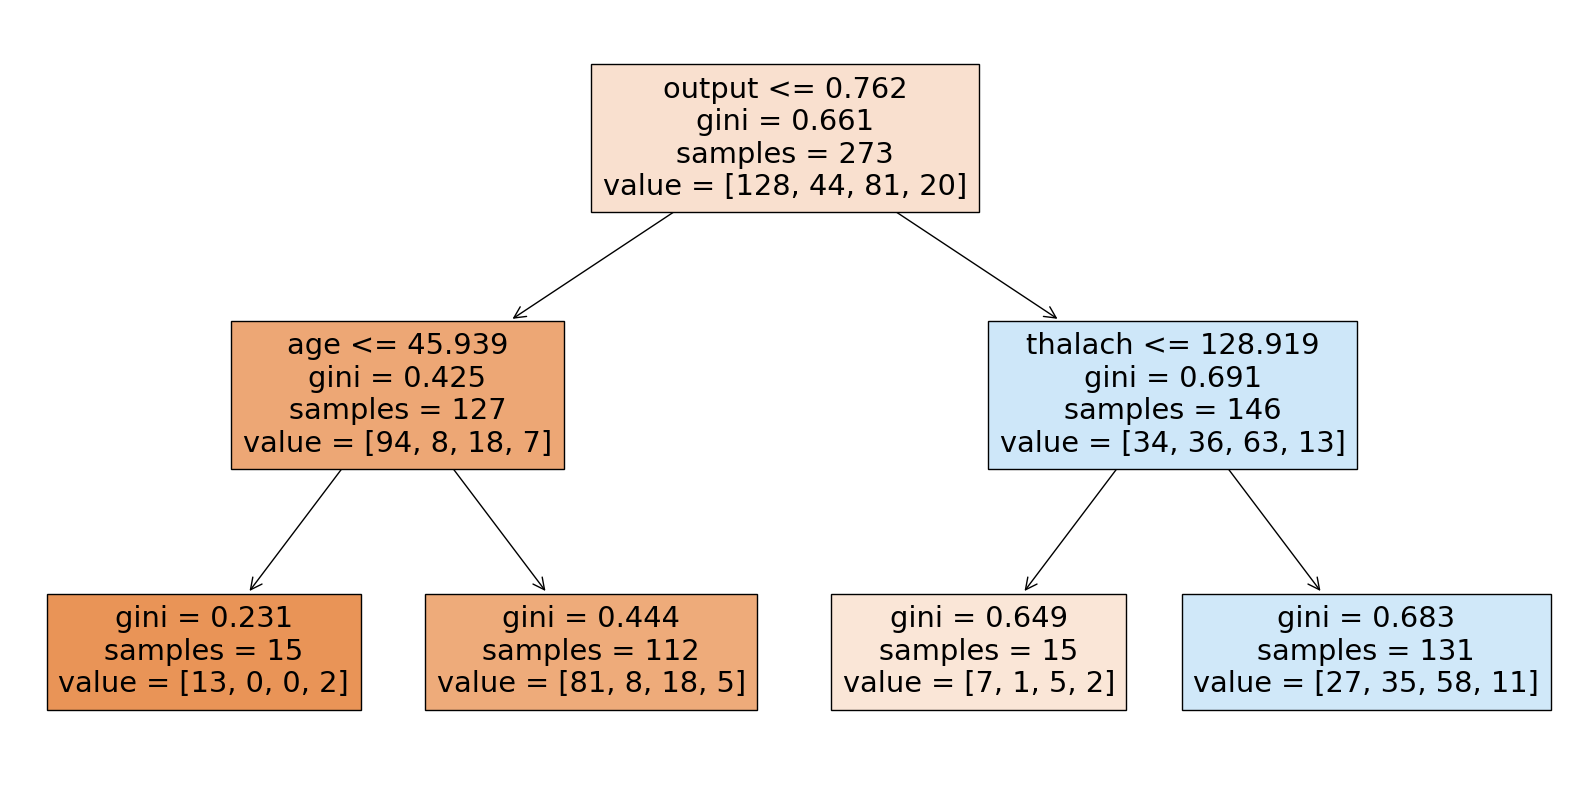

In [7]:
#plotting tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
modelDT = DecisionTreeClassifier(criterion ='gini',splitter='random',max_depth=2,min_samples_split=10,
                                 min_samples_leaf=1)
modelDT.fit(X, y)
plt.figure(figsize=(20,10))
plot_tree(modelDT, filled=True, feature_names=list(X.columns))
plt.show()

The first split is on the output. It splits at .661 but output is binary so really it's saying if output is 0 we go to the left side, and if it's 1 we go to the right side. Those with output 0 (and so the doctor did not diagnose heart attack risk) then split on the thalach variable at 133.6. If the output was one, then the decision is based on sex; 0 goes left and 1 goes right. We can also see from the values list in each node and leaf that on the left side of the tree, the first element in the list tends to be quite high compared to the others. This is the amount of samples from the first category, for chest pain, so chest pain of 0. This seems to make sense that a lot of patients reporting no chest pain are then told they are not at risk for heart attack.

In [8]:
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", LinearDiscriminantAnalysis())
])
#Grid search grid
grid = {}

#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

#Get best params and corresponding model score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model Score:", best_score)
print("That model's used params:", best_params)


Best model Score: 0.5424242424242424
That model's used params: {}


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [9]:
ha['cp_is_3'] = list(map(lambda x: 1 if x == 3 else 0, list(ha['cp'])))
#Efficient :) 
ha['cp_is_2'] = list(map(lambda x: 1 if x == 2 else 0, list(ha['cp'])))
ha['cp_is_1'] = list(map(lambda x: 1 if x == 1 else 0, list(ha['cp'])))
ha['cp_is_0'] = list(map(lambda x: 1 if x == 0 else 0, list(ha['cp'])))

In [10]:
#f1 score is 0 bc it's predicting all the other group and saying that's the best approach

In [11]:
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", LogisticRegression(max_iter=1000))
])
import warnings
from sklearn.linear_model import LogisticRegression

#Ignore annoying warnings
warnings.filterwarnings("ignore")
#Grid search grid
grid = {'model__penalty': [None,'l2'],
        'model__tol': [0.00001,0.0001,0.001,0.01,0.1,1,10],
        'model__C': [1,2,3,4,5],
        'model__fit_intercept': [False,True],
        'model__solver': ['lbfgs', 'liblinear','sag', 'saga'],
        'model__max_iter': [1000]
       }

#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='f1')
grid_search.fit(X, ha['cp_is_3'])

#Get best params and corresponding model score
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#Values vary when re-run!
print("Best model Score:", best_score)
print("That model's used params:", best_params)

Best model Score: 0.0
That model's used params: {'model__C': 1, 'model__fit_intercept': False, 'model__max_iter': 1000, 'model__penalty': None, 'model__solver': 'lbfgs', 'model__tol': 1e-05}


In [12]:
#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='f1')
grid_search.fit(X, ha['cp_is_2'])

#Get best params and corresponding model score
best_score = grid_search.best_score_

#Values vary when re-run!
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#Values vary when re-run!
print("Best model Score:", best_score)
print("That model's used params:", best_params)

Best model Score: 0.24083815825751312
That model's used params: {'model__C': 5, 'model__fit_intercept': True, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'sag', 'model__tol': 10}


In [13]:
#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='f1')
grid_search.fit(X, ha['cp_is_1'])

#Get best params and corresponding model score
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#Values vary when re-run!
print("Best model Score:", best_score)
print("That model's used params:", best_params)

Best model Score: 0.05806451612903226
That model's used params: {'model__C': 1, 'model__fit_intercept': False, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'sag', 'model__tol': 10}


In [14]:
#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='f1')
grid_search.fit(X, ha['cp_is_0'])

#Get best params and corresponding model score
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#Values vary when re-run!
print("Best model Score:", best_score)
print("That model's used params:", best_params)

Best model Score: 0.6640830725855803
That model's used params: {'model__C': 4, 'model__fit_intercept': False, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'model__tol': 0.001}


It seems OvR was best at distinguishing category 0, so no chest pain. This makes sense since the other categories were varying degrees of chest pain which are all much more similar compared to no chest pain.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [15]:
ha_01 = ha[(ha['cp_is_0'] == 1) | (ha['cp_is_1'] == 1)]
ha_02 = ha[(ha['cp_is_0'] == 1) | (ha['cp_is_2'] == 1)]
ha_03 = ha[(ha['cp_is_0'] == 1) | (ha['cp_is_3'] == 1)]

In [16]:
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", LogisticRegression(max_iter=1000))
])
import warnings
from sklearn.linear_model import LogisticRegression

#Ignore annoying warnings
warnings.filterwarnings("ignore", message="Setting penalty=None will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

#Grid search grid
grid = {'model__penalty': [None,'l2'],
        'model__tol': [0.00001,0.0001,0.001,0.01,0.1,1,10],
        'model__C': [1,2,3,4,5],
        'model__fit_intercept': [False,True],
        'model__solver': ['lbfgs', 'liblinear','sag', 'saga'],
        'model__max_iter': [1000]
       }

#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='roc_auc')

y = ha_01['cp']
X = ha_01[['age', 'sex', 'trtbps', 'chol', 'restecg', 'thalach', 'output']]

grid_search.fit(X, y)

#Get best params and corresponding model score
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#Values vary when re-run!
print("Best model ROC AUC Score:", best_score)
print("That model's used params:", best_params)

Best model ROC AUC Score: 0.8378931623931625
That model's used params: {'model__C': 4, 'model__fit_intercept': True, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'model__tol': 1e-05}


In [17]:
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", LogisticRegression(max_iter=1000))
])
import warnings
from sklearn.linear_model import LogisticRegression

#Ignore annoying warnings
warnings.filterwarnings("ignore", message="Setting penalty=None will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

#Grid search grid
grid = {'model__penalty': [None,'l2'],
        'model__tol': [0.00001,0.0001,0.001,0.01,0.1,1,10],
        'model__C': [1,2,3,4,5],
        'model__fit_intercept': [False,True],
        'model__solver': ['lbfgs', 'liblinear','sag', 'saga'],
        'model__max_iter': [1000]
       }

#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='roc_auc')

y = ha_02['cp']
X = ha_02[['age', 'sex', 'trtbps', 'chol', 'restecg', 'thalach', 'output']]

grid_search.fit(X, y)

#Get best params and corresponding model score
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#Values vary when re-run!
print("Best model ROC AUC Score:", best_score)
print("That model's used params:", best_params)

Best model ROC AUC Score: 0.756524886877828
That model's used params: {'model__C': 1, 'model__fit_intercept': True, 'model__max_iter': 1000, 'model__penalty': None, 'model__solver': 'lbfgs', 'model__tol': 1e-05}


In [18]:
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", LogisticRegression(max_iter=1000))
])
import warnings
from sklearn.linear_model import LogisticRegression

#Ignore annoying warnings
warnings.filterwarnings("ignore", message="Setting penalty=None will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

#Grid search grid
grid = {'model__penalty': [None,'l2'],
        'model__tol': [0.00001,0.0001,0.001,0.01,0.1,1,10],
        'model__C': [1,2,3,4,5],
        'model__fit_intercept': [False,True],
        'model__solver': ['lbfgs', 'liblinear','sag', 'saga'],
        'model__max_iter': [1000]
       }

#Grid search with cross validation
grid_search = GridSearchCV(pipe, grid, cv=5, scoring='roc_auc')

y = ha_03['cp']
X = ha_03[['age', 'sex', 'trtbps', 'chol', 'restecg', 'thalach', 'output']]

grid_search.fit(X, y)

#Get best params and corresponding model score
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#Values vary when re-run!
print("Best model ROC AUC Score:", best_score)
print("That model's used params:", best_params)

Best model ROC AUC Score: 0.7353846153846153
That model's used params: {'model__C': 4, 'model__fit_intercept': True, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'model__tol': 1e-05}


OvO was best at distinguishing between the pair of cp value of 0 and 1. So no chest pain versus typical angina.